# Analyse results

This notebook compares the output of the two compression methods and also
demonstrates how to extract the relative contribution of an area of interest
with the netCDF files.

In [1]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

## Compare compression methods

In [2]:
xds_fp32 = xr.open_dataset('results/2022-06_ffp.nc')
xds_uint16 = xr.open_dataset('results/2022-06_ffp_lossy.nc')

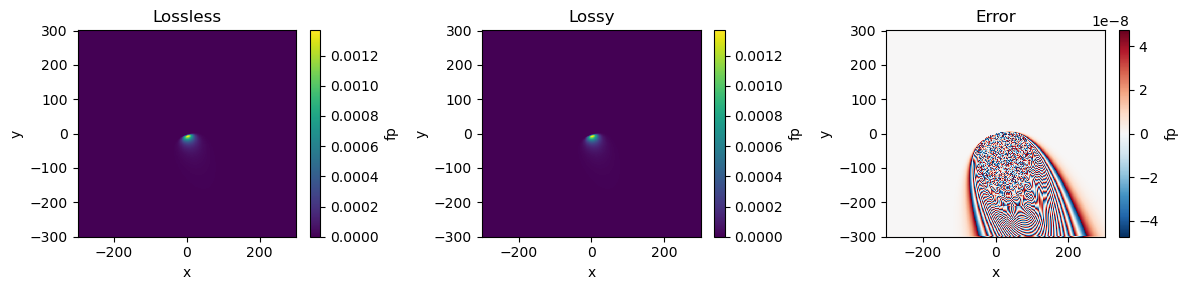

In [3]:
# Example from one timestep
fig, ax = plt.subplots(1, 3, figsize=(12,3))

xds_fp32.isel(time=0)['fp'].plot(ax=ax[0])
xds_uint16.isel(time=0)['fp'].plot(ax=ax[1])
(xds_fp32.isel(time=0)['fp'] - xds_uint16.isel(time=0)['fp']).plot(ax=ax[2])

ax[0].set_title('Lossless')
ax[1].set_title('Lossy')
ax[2].set_title('Error')

plt.tight_layout()
plt.show()

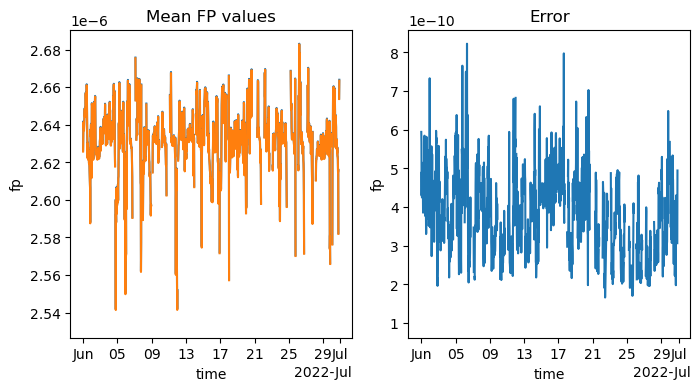

In [4]:
# Mean FP values for each timestep
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

mean_fp32 = xds_fp32['fp'].mean(axis=(1,2))
mean_uint16 = xds_uint16['fp'].mean(axis=(1,2))

mean_fp32.plot(ax=ax[0])
mean_uint16.plot(ax=ax[0])

ax[0].set_title('Mean FP values')

# Error
(mean_fp32 - mean_uint16).plot(ax=ax[1])

ax[1].set_title('Error')

plt.show()

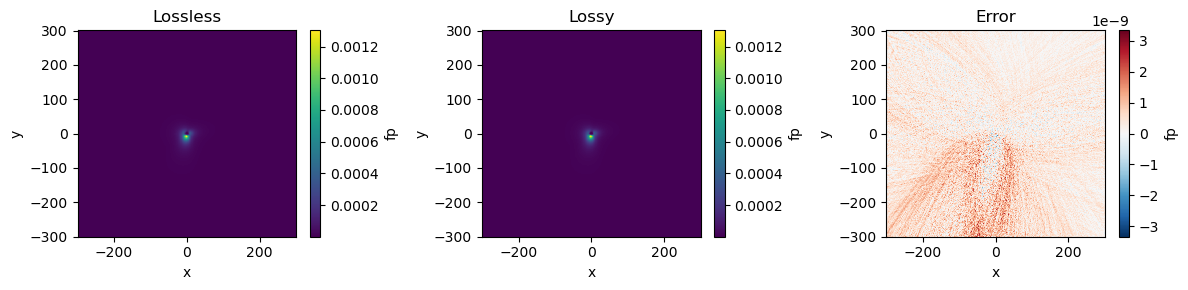

In [5]:
# Mean spatial error
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

mean_fp32 = xds_fp32['fp'].mean(axis=0)
mean_uint16 = xds_uint16['fp'].mean(axis=0)

mean_fp32.plot(ax=ax[0])
mean_uint16.plot(ax=ax[1])
(mean_fp32 - mean_uint16).plot(ax=ax[2])

ax[0].set_title('Lossless')
ax[1].set_title('Lossy')
ax[2].set_title('Error')

plt.tight_layout()
plt.show()

## Extract footprint contribution from area of interest

<Axes: >

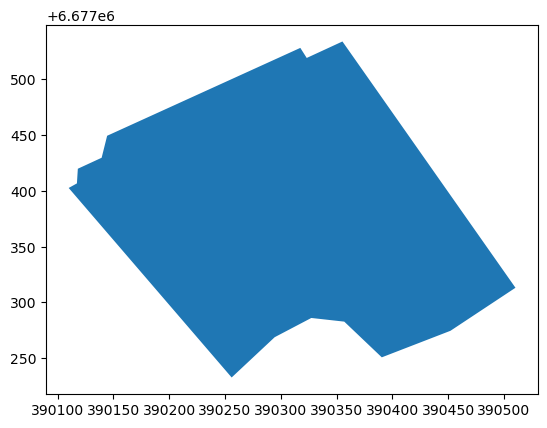

In [6]:
# Position of EC tower
ec_x = 390339.6
ec_y = 6677535

# Field: area of interest
field = gpd.read_file('data/field.gpkg')
field.plot()

In [7]:
# Add x and y offsets
def add_xy_offsets(xds, yoff, xoff, epsg):
    if not 'spatial_ref' in xds.coords:
        xds['y'] = xds['y'].astype('float32') + yoff
        xds['x'] = xds['x'].astype('float32') + xoff
        # Write coordinate system
        xds = xds.rio.write_crs(epsg)
    return xds

xds_fp32 = add_xy_offsets(xds_fp32, ec_y, ec_x, 3067)
xds_uint16 = add_xy_offsets(xds_uint16, ec_y, ec_x, 3067)

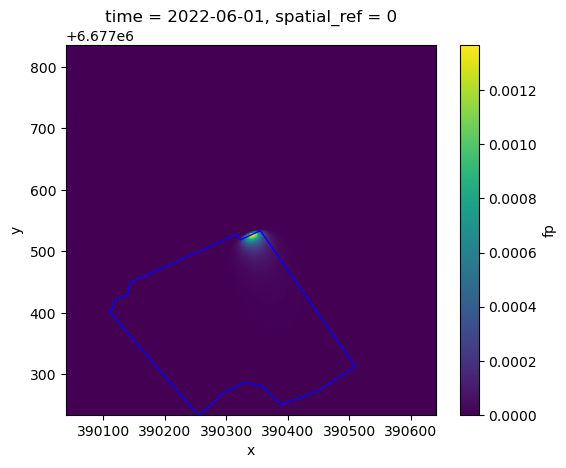

In [8]:
# Plot example with aoi
fig, ax = plt.subplots()

xds_fp32['fp'].isel(time=0).plot(ax=ax)
field.plot(facecolor='none', edgecolor='blue', ax=ax)

plt.show()

In [9]:
def calc_cb(xds):
    # Clip xarray
    xds_clipped = xds.rio.clip(field.geometry)
    # Take sum inside clipped area
    cb_clip = xds_clipped.fp.sum(dim=(['x', 'y']))
    # Take total sum
    cb_all = xds.fp.sum(dim=(['x', 'y']))
    # Calculate cb %
    cb = (cb_clip / cb_all)
    # Result
    cb = cb.to_dataframe().reset_index()[['time', 'fp']].set_index('time')
    
    return cb

In [10]:
cb_fp32 = calc_cb(xds_fp32)
cb_uint16 = calc_cb(xds_uint16)

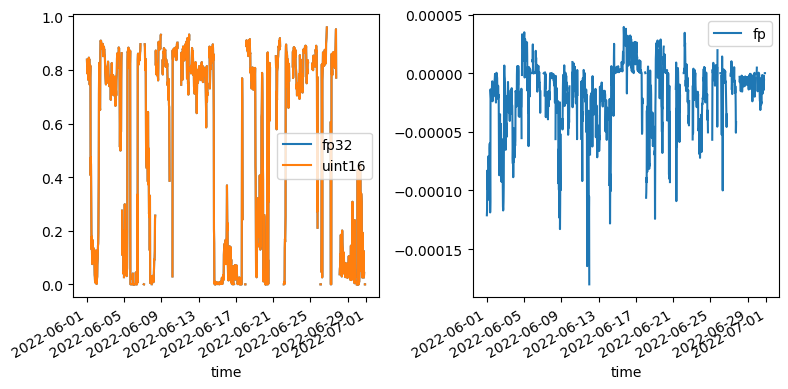

In [11]:
# Differences are nice and small
fig, ax = plt.subplots(1, 2, figsize=(8,4))

cb_fp32.plot(y='fp', label='fp32', ax=ax[0])
cb_uint16.plot(y='fp', label='uint16', ax=ax[0])

(cb_fp32 - cb_uint16).plot(label='error', ax=ax[1])

plt.tight_layout()
plt.show()